## 2.3 Database Architecture

### Structured Data with MySQL
We use MySQL to handle all structured metadata from Spotify, including:
- **Core song attributes**: Track IDs, titles, artists, and release dates
- **Audio features**: Valence, energy, tempo, and popularity scores
- **Genre relationships**: Implemented through normalized tables supporting many-to-many relationships between songs and genres

The relational design enables:
- Complex analytical queries across temporal and genre dimensions
- Data integrity through strict schema enforcement
- Optimized performance via indexing on frequently queried fields

### Unstructured Data with MongoDB
MongoDB stores our unstructured lyrical content and NLP outputs with:
- **Full lyric texts** in their original format
- **Sentiment analysis results** from multiple methods (VADER, TextBlob)
- **Derived metrics** including emotion distributions and linguistic features
- **Metadata** about the lyrics themselves (language, line count, etc.)

The document model provides:
- Flexible schema for evolving NLP outputs
- Efficient storage and retrieval of text content
- Horizontal scalability for large lyric datasets

### Integrated Data Pipeline
1. **Ingestion**: Spotify metadata flows to MySQL while lyrics populate MongoDB
2. **Linking**: Universal track IDs maintain referential integrity between systems
3. **Analysis**: Combined queries merge audio features with lyrical sentiment
4. **Optimization**: Each database plays to its strengths:
   - MySQL for complex aggregations
   - MongoDB for text storage and retrieval

**Key Benefits**:
- Maintains data integrity where needed (MySQL)
- Preserves flexibility for textual analysis (MongoDB)
- Enables comprehensive music sentiment research

In [4]:
#Using MongoDB and pyMongo to update sentiments lyrics data 
from pymongo import MongoClient
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

client = MongoClient("mongodb://localhost:27017/")
db = client["Spotify_Lyrics"]
collection = db["Lyrics_data"]

analyzer = SentimentIntensityAnalyzer()

for doc in collection.find({"status": "success", "lyrics": {"$exists": True}}):
    lyrics = doc["lyrics"]

    # VADER sentiment scores
    vader_scores = analyzer.polarity_scores(lyrics)
    vader_compound = vader_scores['compound']

    # TextBlob polarity (-1 to 1)
    textblob_polarity = TextBlob(lyrics).sentiment.polarity

    # Update MongoDB doc with sentiment scores
    collection.update_one(
        {"_id": doc["_id"]},
        {"$set": {
            "sentiment_vader": vader_compound,
            "sentiment_textblob": textblob_polarity
        }}
    )

    print(f"Updated sentiments for '{doc['title']}' by {doc['artist']}")




Updated sentiments for '2024Lyrics' by 
Updated sentiments for '2022Lyrics' by 
Updated sentiments for '2023Lyrics' by 
Updated sentiments for '2020Lyrics' by 
Updated sentiments for '2021Lyrics' by 
Updated sentiments for '2019Lyrics' by 
Updated sentiments for '2024Lyrics' by 
Updated sentiments for '2022Lyrics' by 
Updated sentiments for '2023Lyrics' by 
Updated sentiments for '2020Lyrics' by 
Updated sentiments for '2021Lyrics' by 
Updated sentiments for '2019Lyrics' by 
Updated sentiments for 'Espresso' by Sabrina Carpenter
Updated sentiments for 'Die With A Smile' by Lady Gaga,Bruno Mars
Updated sentiments for 'Birds Of A Feather' by Billie Eilish
Updated sentiments for 'Not Like Us' by Kendrick Lamar
Updated sentiments for 'Beautiful Things' by Benson Boone
Updated sentiments for 'We Can'T Be Friends (Wait For Your Love)' by Ariana Grande
Updated sentiments for 'Good Luck Babe!' by Chappell Roan
Updated sentiments for 'Please Please Please' by Sabrina Carpenter
Updated sentiment

In [2]:
for doc in collection.find({"status": "success", "lyrics": { "$exists": True }}):
    title = doc.get("title", "Unknown Title")
    artist = doc.get("artist", "Unknown Artist")
    lyrics = doc.get("lyrics", "")

    if not lyrics.strip():
        print(f"⚠️ Skipping empty lyrics for: {title} by {artist}")
        continue

    # Analyze sentiment
    vader_scores = analyzer.polarity_scores(lyrics)
    vader_compound = vader_scores['compound']
    textblob_polarity = TextBlob(lyrics).sentiment.polarity

    # Update DB
    collection.update_one(
        { "_id": doc["_id"] },
        { "$set": {
            "sentiment_vader": vader_compound,
            "sentiment_textblob": textblob_polarity
        }}
    )

    print(f"✅ Updated: {title} by {artist}")


✅ Updated: 2024Lyrics by 
✅ Updated: 2022Lyrics by 
✅ Updated: 2023Lyrics by 
✅ Updated: 2020Lyrics by 
✅ Updated: 2021Lyrics by 
✅ Updated: 2019Lyrics by 
✅ Updated: 2024Lyrics by 
✅ Updated: 2022Lyrics by 
✅ Updated: 2023Lyrics by 
✅ Updated: 2020Lyrics by 
✅ Updated: 2021Lyrics by 
✅ Updated: 2019Lyrics by 
✅ Updated: Espresso by Sabrina Carpenter
✅ Updated: Die With A Smile by Lady Gaga,Bruno Mars
✅ Updated: Birds Of A Feather by Billie Eilish
⚠️ Skipping empty lyrics for: Not Like Us by Kendrick Lamar
✅ Updated: Beautiful Things by Benson Boone
✅ Updated: We Can'T Be Friends (Wait For Your Love) by Ariana Grande
✅ Updated: Good Luck Babe! by Chappell Roan
✅ Updated: Please Please Please by Sabrina Carpenter
✅ Updated: End Of Beginning by Djo
✅ Updated: Apt. by Rosé,Bruno Mars
✅ Updated: Yes And? by Ariana Grande
✅ Updated: I Like The Way You Kiss Me by Artemas
✅ Updated: Taste by Sabrina Carpenter
✅ Updated: Fortnight (Feat. Post Malone) by Taylor Swift,Post Malone
✅ Updated: Fe!N

In [5]:
import re
from pymongo import MongoClient
from datetime import datetime
import os

client = MongoClient("mongodb://localhost:27017/")
db = client["Spotify_Lyrics"]
collection = db["Lyrics_data"]

def parse_lyrics_file(filepath, year):
    with open(filepath, 'r', encoding='utf-8') as f:
        content = f.read()

    # Match: Lyrics for 'Title' by Artist:
    pattern = re.compile(r"Lyrics for '(.+?)' by (.+?):")
    matches = list(pattern.finditer(content))

    for i, match in enumerate(matches):
        title = match.group(1).strip()
        artist = match.group(2).strip()
        start = match.end()
        end = matches[i + 1].start() if i + 1 < len(matches) else len(content)
        lyrics_block = content[start:end].strip()

        lines = lyrics_block.split('\n')
        lyrics = '\n'.join(lines[5:]).strip()  # remove first few metadata lines

        doc = {
            "title": title,
            "artist": artist,
            "lyrics": lyrics,
            "year": year,
            "retrieved_at": datetime.utcnow(),
            "status": "success",
            "error": None
        }

        collection.insert_one(doc)
        print(f"✅ Inserted: {title} by {artist} ({year})")

# Example usage: one file per year
parse_lyrics_file("lyrics_data/2019lyrics.txt", year=2019)


✅ Inserted: Señorita by Shawn Mendes,Camila Cabello (2019)
✅ Inserted: 7 rings by Ariana Grande (2019)
✅ Inserted: Lost in the Fire (feat. The Weeknd) by Gesaffelstein,The Weeknd (2019)
✅ Inserted: Without Me by Halsey (2019)
✅ Inserted: Doin' Time by Lana Del Rey (2019)
✅ Inserted: Shallow by Lady Gaga,Bradley Cooper (2019)
✅ Inserted: break up with your girlfriend i'm bored by Ariana Grande (2019)
✅ Inserted: Someone You Loved by Lewis Capaldi (2019)
✅ Inserted: Nights Like This (feat. Ty Dolla $ign) by Kehlani,Ty Dolla $ign (2019)
✅ Inserted: Please Me by Cardi B,Bruno Mars (2019)
✅ Inserted: Lose You To Love Me by Selena Gomez (2019)
✅ Inserted: when the party's over by Billie Eilish (2019)
✅ Inserted: Dancing With A Stranger (with Normani) by Sam Smith,Normani (2019)
✅ Inserted: Motivation by Normani (2019)
✅ Inserted: Better by Khalid (2019)
✅ Inserted: Juicy by Doja Cat,Tyga (2019)
✅ Inserted: My Type by Saweetie (2019)
✅ Inserted: Easier by 5 Seconds of Summer (2019)
✅ Inserted

In [5]:
import re
from pymongo import MongoClient
from datetime import datetime
import os

client = MongoClient("mongodb://localhost:27017/")
db = client["Spotify_Lyrics"]
collection = db["Lyrics_data"]

def parse_lyrics_file(filepath, year):
    with open(filepath, 'r', encoding='utf-8') as f:
        content = f.read()

    # Match: Lyrics for 'Title' by Artist:
    pattern = re.compile(r"Lyrics for '(.+?)' by (.+?):")
    matches = list(pattern.finditer(content))

    for i, match in enumerate(matches):
        title = match.group(1).strip()
        artist = match.group(2).strip()
        start = match.end()
        end = matches[i + 1].start() if i + 1 < len(matches) else len(content)
        lyrics_block = content[start:end].strip()

        lines = lyrics_block.split('\n')
        lyrics = '\n'.join(lines[5:]).strip()  # remove first few metadata lines

        doc = {
            "title": title,
            "artist": artist,
            "lyrics": lyrics,
            "year": year,
            "retrieved_at": datetime.utcnow(),
            "status": "success",
            "error": None
        }

        collection.insert_one(doc)
        print(f"✅ Inserted: {title} by {artist} ({year})")

# Example usage: one file per year
parse_lyrics_file("lyrics_data/2020lyrics.txt", year=2020)


✅ Inserted: cardigan by Taylor Swift (2020)
✅ Inserted: death bed (coffee for your head) by Powfu,beabadoobee (2020)
✅ Inserted: The Box by Roddy Ricch (2020)
✅ Inserted: ROXANNE by Arizona Zervas (2020)
✅ Inserted: positions by Ariana Grande (2020)
✅ Inserted: Say So by Doja Cat (2020)
✅ Inserted: Watermelon Sugar by Harry Styles (2020)
✅ Inserted: Don't Start Now by Dua Lipa (2020)
✅ Inserted: everything i wanted by Billie Eilish (2020)
✅ Inserted: august by Taylor Swift (2020)
✅ Inserted: What You Know Bout Love by Pop Smoke (2020)
✅ Inserted: DÁKITI by Bad Bunny,JHAYCO (2020)
✅ Inserted: WAP (feat. Megan Thee Stallion) by Cardi B,Megan Thee Stallion (2020)
✅ Inserted: ROCKSTAR (feat. Roddy Ricch) by DaBaby,Roddy Ricch (2020)
✅ Inserted: Blueberry Faygo by Lil Mosey (2020)
✅ Inserted: Mood (feat. iann dior) by 24kGoldn,iann dior (2020)
✅ Inserted: Rain On Me (with Ariana Grande) by Lady Gaga,Ariana Grande (2020)
✅ Inserted: Dynamite by BTS (2020)
✅ Inserted: Kings & Queens by Ava Ma

In [6]:
import re
from pymongo import MongoClient
from datetime import datetime
import os

client = MongoClient("mongodb://localhost:27017/")
db = client["Spotify_Lyrics"]
collection = db["Lyrics_data"]

def parse_lyrics_file(filepath, year):
    with open(filepath, 'r', encoding='utf-8') as f:
        content = f.read()

    # Match: Lyrics for 'Title' by Artist:
    pattern = re.compile(r"Lyrics for '(.+?)' by (.+?):")
    matches = list(pattern.finditer(content))

    for i, match in enumerate(matches):
        title = match.group(1).strip()
        artist = match.group(2).strip()
        start = match.end()
        end = matches[i + 1].start() if i + 1 < len(matches) else len(content)
        lyrics_block = content[start:end].strip()

        lines = lyrics_block.split('\n')
        lyrics = '\n'.join(lines[5:]).strip()  # remove first few metadata lines

        doc = {
            "title": title,
            "artist": artist,
            "lyrics": lyrics,
            "year": year,
            "retrieved_at": datetime.utcnow(),
            "status": "success",
            "error": None
        }

        collection.insert_one(doc)
        print(f"✅ Inserted: {title} by {artist} ({year})")

# Example usage: one file per year
parse_lyrics_file("lyrics_data/2021lyrics.txt", year=2021)


✅ Inserted: Happier Than Ever by Billie Eilish (2021)
✅ Inserted: deja vu by Olivia Rodrigo (2021)
✅ Inserted: Good Days by SZA (2021)
✅ Inserted: Kiss Me More (feat. SZA) by Doja Cat,SZA (2021)
✅ Inserted: good 4 u by Olivia Rodrigo (2021)
✅ Inserted: Beggin' by Måneskin (2021)
✅ Inserted: Leave The Door Open by Bruno Mars,Anderson .Paak,Silk Sonic (2021)
✅ Inserted: Peaches (feat. Daniel Caesar & Giveon) by Justin Bieber,Daniel Caesar,GIVĒON (2021)
✅ Inserted: Heartbreak Anniversary by GIVĒON (2021)
✅ Inserted: MONTERO (Call Me By Your Name) by Lil Nas X (2021)
✅ Inserted: 34+35 by Ariana Grande (2021)
✅ Inserted: Woman by Doja Cat (2021)
✅ Inserted: Levitating (feat. DaBaby) by Dua Lipa,DaBaby (2021)
✅ Inserted: telepatía by Kali Uchis (2021)
✅ Inserted: Easy On Me by Adele (2021)
✅ Inserted: All Too Well (10 Minute Version) (Taylor's Version) (From The Vault) by Taylor Swift (2021)
✅ Inserted: pov by Ariana Grande (2021)
✅ Inserted: Pain by PinkPantheress (2021)
✅ Inserted: Streets

In [7]:
import re
from pymongo import MongoClient
from datetime import datetime
import os

client = MongoClient("mongodb://localhost:27017/")
db = client["Spotify_Lyrics"]
collection = db["Lyrics_data"]

def parse_lyrics_file(filepath, year):
    with open(filepath, 'r', encoding='utf-8') as f:
        content = f.read()

    # Match: Lyrics for 'Title' by Artist:
    pattern = re.compile(r"Lyrics for '(.+?)' by (.+?):")
    matches = list(pattern.finditer(content))

    for i, match in enumerate(matches):
        title = match.group(1).strip()
        artist = match.group(2).strip()
        start = match.end()
        end = matches[i + 1].start() if i + 1 < len(matches) else len(content)
        lyrics_block = content[start:end].strip()

        lines = lyrics_block.split('\n')
        lyrics = '\n'.join(lines[5:]).strip()  # remove first few metadata lines

        doc = {
            "title": title,
            "artist": artist,
            "lyrics": lyrics,
            "year": year,
            "retrieved_at": datetime.utcnow(),
            "status": "success",
            "error": None
        }

        collection.insert_one(doc)
        print(f"✅ Inserted: {title} by {artist} ({year})")

# Example usage: one file per year
parse_lyrics_file("lyrics_data/2022lyrics.txt", year=2022)


✅ Inserted: As It Was by Harry Styles (2022)
✅ Inserted: Anti-Hero by Taylor Swift (2022)
✅ Inserted: Heat Waves by Glass Animals (2022)
✅ Inserted: Running Up That Hill (A Deal With God) - 2018 Remaster by Kate Bush (2022)
✅ Inserted: Tití Me Preguntó by Bad Bunny (2022)
✅ Inserted: INDUSTRY BABY (feat. Jack Harlow) by Lil Nas X,Jack Harlow (2022)
✅ Inserted: Unholy (feat. Kim Petras) by Sam Smith,Kim Petras (2022)
✅ Inserted: CUFF IT by Beyoncé (2022)
✅ Inserted: First Class by Jack Harlow (2022)
✅ Inserted: Late Night Talking by Harry Styles (2022)
✅ Inserted: traitor by Olivia Rodrigo (2022)
✅ Inserted: Ghost by Justin Bieber (2022)
✅ Inserted: Glimpse of Us by Joji (2022)
✅ Inserted: Bad Habit by Steve Lacy (2022)
✅ Inserted: Something in the Orange by Zach Bryan (2022)
✅ Inserted: Is There Someone Else? by The Weeknd (2022)
✅ Inserted: Quevedo: Bzrp Music Sessions Vol. 52 by Bizarrap,Quevedo (2022)
✅ Inserted: Me Porto Bonito by Bad Bunny,Chencho Corleone (2022)
✅ Inserted: N95 b

In [8]:
import re
from pymongo import MongoClient
from datetime import datetime
import os

client = MongoClient("mongodb://localhost:27017/")
db = client["Spotify_Lyrics"]
collection = db["Lyrics_data"]

def parse_lyrics_file(filepath, year):
    with open(filepath, 'r', encoding='utf-8') as f:
        content = f.read()

    # Match: Lyrics for 'Title' by Artist:
    pattern = re.compile(r"Lyrics for '(.+?)' by (.+?):")
    matches = list(pattern.finditer(content))

    for i, match in enumerate(matches):
        title = match.group(1).strip()
        artist = match.group(2).strip()
        start = match.end()
        end = matches[i + 1].start() if i + 1 < len(matches) else len(content)
        lyrics_block = content[start:end].strip()

        lines = lyrics_block.split('\n')
        lyrics = '\n'.join(lines[5:]).strip()  # remove first few metadata lines

        doc = {
            "title": title,
            "artist": artist,
            "lyrics": lyrics,
            "year": year,
            "retrieved_at": datetime.utcnow(),
            "status": "success",
            "error": None
        }

        collection.insert_one(doc)
        print(f"✅ Inserted: {title} by {artist} ({year})")

# Example usage: one file per year
parse_lyrics_file("lyrics_data/2023lyrics.txt", year=2023)


✅ Inserted: Kill Bill by SZA (2023)
✅ Inserted: Flowers by Miley Cyrus (2023)
✅ Inserted: Die For You - Remix by The Weeknd,Ariana Grande (2023)
✅ Inserted: Boy's a liar Pt. 2 by PinkPantheress,Ice Spice (2023)
✅ Inserted: Cruel Summer by Taylor Swift (2023)
✅ Inserted: vampire by Olivia Rodrigo (2023)
✅ Inserted: greedy by Tate McRae (2023)
✅ Inserted: Here With Me by d4vd (2023)
✅ Inserted: Moonlight by Kali Uchis (2023)
✅ Inserted: Daylight by David Kushner (2023)
✅ Inserted: My Love Mine All Mine by Mitski (2023)
✅ Inserted: Cupid - Twin Ver. by FIFTY FIFTY (2023)
✅ Inserted: See You Again (feat. Kali Uchis) by Tyler The Creator,Kali Uchis (2023)
✅ Inserted: Seven (feat. Latto) by Jung Kook,Latto (2023)
✅ Inserted: Water by Tyla (2023)
✅ Inserted: Lovin On Me by Jack Harlow (2023)
✅ Inserted: Paint The Town Red by Doja Cat (2023)
✅ Inserted: Shakira: Bzrp Music Sessions Vol. 53 by Bizarrap,Shakira (2023)
✅ Inserted: Nonsense by Sabrina Carpenter (2023)
✅ Inserted: Karma by Taylor S

In [9]:
import re
from pymongo import MongoClient
from datetime import datetime
import os

client = MongoClient("mongodb://localhost:27017/")
db = client["Spotify_Lyrics"]
collection = db["Lyrics_data"]

def parse_lyrics_file(filepath, year):
    with open(filepath, 'r', encoding='utf-8') as f:
        content = f.read()

    # Match: Lyrics for 'Title' by Artist:
    pattern = re.compile(r"Lyrics for '(.+?)' by (.+?):")
    matches = list(pattern.finditer(content))

    for i, match in enumerate(matches):
        title = match.group(1).strip()
        artist = match.group(2).strip()
        start = match.end()
        end = matches[i + 1].start() if i + 1 < len(matches) else len(content)
        lyrics_block = content[start:end].strip()

        lines = lyrics_block.split('\n')
        lyrics = '\n'.join(lines[5:]).strip()  # remove first few metadata lines

        doc = {
            "title": title,
            "artist": artist,
            "lyrics": lyrics,
            "year": year,
            "retrieved_at": datetime.utcnow(),
            "status": "success",
            "error": None
        }

        collection.insert_one(doc)
        print(f"✅ Inserted: {title} by {artist} ({year})")

# Example usage: one file per year
parse_lyrics_file("lyrics_data/2024lyrics.txt", year=2024)


✅ Inserted: Espresso by Sabrina Carpenter (2024)
✅ Inserted: Die With A Smile by Lady Gaga,Bruno Mars (2024)
✅ Inserted: BIRDS OF A FEATHER by Billie Eilish (2024)
✅ Inserted: Beautiful Things by Benson Boone (2024)
✅ Inserted: we can't be friends (wait for your love) by Ariana Grande (2024)
✅ Inserted: Good Luck Babe! by Chappell Roan (2024)
✅ Inserted: Please Please Please by Sabrina Carpenter (2024)
✅ Inserted: End of Beginning by Djo (2024)
✅ Inserted: APT. by ROSÉ,Bruno Mars (2024)
✅ Inserted: yes and? by Ariana Grande (2024)
✅ Inserted: i like the way you kiss me by Artemas (2024)
✅ Inserted: Taste by Sabrina Carpenter (2024)
✅ Inserted: Fortnight (feat. Post Malone) by Taylor Swift,Post Malone (2024)
✅ Inserted: FE!N (feat. Playboi Carti) by Travis Scott,Playboi Carti (2024)
✅ Inserted: Lose Control by Teddy Swims (2024)
✅ Inserted: Stick Season by Noah Kahan (2024)
✅ Inserted: TEXAS HOLD 'EM by Beyoncé (2024)
✅ Inserted: I Had Some Help (Feat. Morgan Wallen) by Post Malone,Morg


🎵 Per-song Sentiment Scores (Sorted by Year):
2019 | when the party's over | VADER: 0.997 | TextBlob: 0.250
2019 | 3 Nights | VADER: -0.747 | TextBlob: -0.143
2019 | How Do You Sleep? | VADER: 0.909 | TextBlob: 0.229
2019 | Easier | VADER: 0.996 | TextBlob: 0.125
2019 | My Type | VADER: 0.762 | TextBlob: 0.070
2019 | Juicy | VADER: 0.556 | TextBlob: 0.393
2019 | Better | VADER: 0.948 | TextBlob: 0.253
2019 | Motivation | VADER: 0.851 | TextBlob: 0.163
2019 | Dancing With A Stranger (with Normani) | VADER: 0.000 | TextBlob: 0.000
2019 | Lose You To Love Me | VADER: 1.000 | TextBlob: 0.344
2019 | Please Me | VADER: 0.967 | TextBlob: 0.000
2019 | Nights Like This (feat. Ty Dolla $ign) | VADER: -0.988 | TextBlob: -0.060
2019 | Someone You Loved | VADER: 0.981 | TextBlob: 0.299
2019 | break up with your girlfriend i'm bored | VADER: 0.989 | TextBlob: -0.007
2019 | Shallow | VADER: -0.655 | TextBlob: 0.000
2019 | Doin' Time | VADER: 0.970 | TextBlob: -0.132
2019 | Without Me | VADER: -0.651

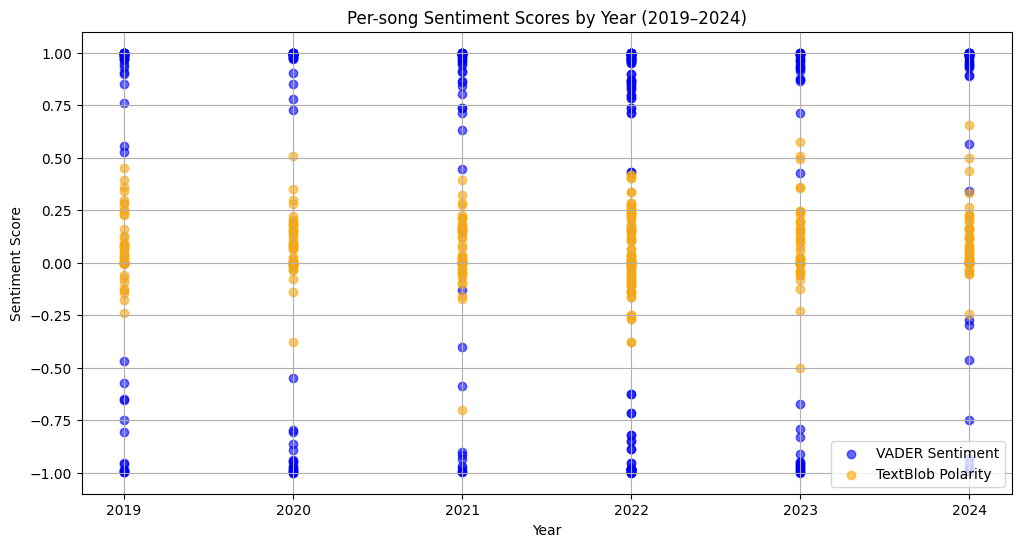


 Full Sorted DataFrame:
     year                          title  sentiment_vader  sentiment_textblob
198  2019          when the party's over           0.9966            0.250000
207  2019                       3 Nights          -0.7473           -0.142870
206  2019              How Do You Sleep?           0.9086            0.228571
204  2019                         Easier           0.9957            0.124790
203  2019                        My Type           0.7621            0.069985
..    ...                            ...              ...                 ...
292  2024                      Too Sweet           0.9984            0.158874
293  2024            MILLION DOLLAR BABY          -0.9936            0.053380
294  2024                          LUNCH           0.9870            0.121065
296  2024  Guess featuring billie eilish           0.8887           -0.033098
320  2024                          Water          -0.9778            0.159615

[321 rows x 4 columns]


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from pymongo import MongoClient

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["Spotify_Lyrics"]
collection = db["Lyrics_data"]

# Query all documents with sentiment scores and valid year
docs = list(collection.find(
    {
        "sentiment_vader": {"$exists": True},
        "sentiment_textblob": {"$exists": True},
        "year": {"$exists": True}
    },
    {
        "title": 1,
        "year": 1,
        "sentiment_vader": 1,
        "sentiment_textblob": 1
    }
))

# Check if data was found
if not docs:
    print("No documents with sentiment data found.")
else:
    # 📊 Load into DataFrame
    df = pd.DataFrame(docs)

    # 🧹 Filter for years 2019–2024
    df = df[df["year"].between(2019, 2024)]

    # ⬆️ Sort by year ascending
    df = df.sort_values(by="year", ascending=True)

    # 🧾 Print song sentiment info
    if df.empty:
        print("No data in years 2019–2024.")
    else:
        print("\n🎵 Per-song Sentiment Scores (Sorted by Year):")
        for idx, row in df.iterrows():
            print(f'{row["year"]} | {row.get("title", "Unknown Title")} | VADER: {row["sentiment_vader"]:.3f} | TextBlob: {row["sentiment_textblob"]:.3f}')

        # Plot sentiment scores
        plt.figure(figsize=(12, 6))
        plt.scatter(df["year"], df["sentiment_vader"], alpha=0.6, label="VADER Sentiment", color="blue")
        plt.scatter(df["year"], df["sentiment_textblob"], alpha=0.6, label="TextBlob Polarity", color="orange")
        plt.title("Per-song Sentiment Scores by Year (2019–2024)")
        plt.xlabel("Year")
        plt.ylabel("Sentiment Score")
        plt.legend()
        plt.grid(True)
        plt.show()

        #  print full sorted DataFrame
        print("\n Full Sorted DataFrame:")
        print(df[["year", "title", "sentiment_vader", "sentiment_textblob"]])



Yearly Average Sentiment:
   year  sentiment_vader  sentiment_textblob
0  2019         0.342189            0.078571
1  2020         0.258406            0.078440
2  2021         0.455876            0.055202
3  2022         0.246191            0.051006
4  2023         0.172933            0.093316
5  2024         0.458853            0.096516
Predicted VADER Sentiment Score for 2025: 0.3341


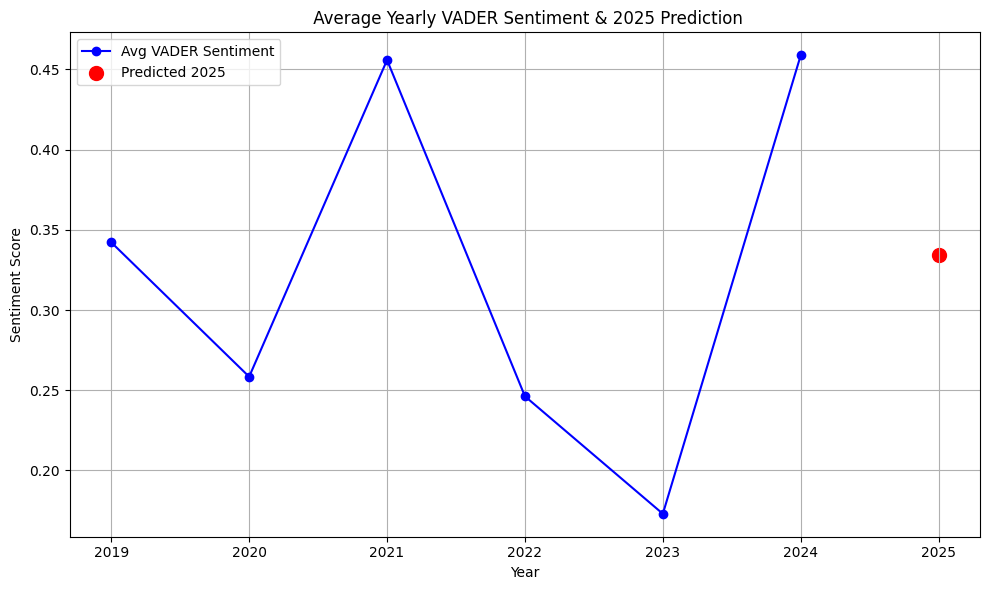

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pymongo import MongoClient
from sklearn.linear_model import LinearRegression

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["Spotify_Lyrics"]
collection = db["Lyrics_data"]

# Query songs with sentiment scores and year info
docs = list(collection.find(
    {
        "sentiment_vader": {"$exists": True},
        "sentiment_textblob": {"$exists": True},
        "year": {"$exists": True}
    },
    {
        "title": 1,
        "year": 1,
        "sentiment_vader": 1,
        "sentiment_textblob": 1
    }
))

if not docs:
    print(" No documents with sentiment data found.")
else:
    # Load into DataFrame
    df = pd.DataFrame(docs)

    # Filter for 2019–2024 and sort by year
    df = df[df["year"].between(2019, 2024)]
    df = df.sort_values(by="year")

    if df.empty:
        print("No data in years 2019–2024.")
    else:
    
        # Group by year and calculate average sentiment
        yearly_sentiment = df.groupby("year")[["sentiment_vader", "sentiment_textblob"]].mean().reset_index()

        print("Yearly Average Sentiment:")
        print(yearly_sentiment)

        # Train regression model to predict 2025 sentiment (VADER)
        X = yearly_sentiment["year"].values.reshape(-1, 1)
        y = yearly_sentiment["sentiment_vader"].values
        model = LinearRegression()
        model.fit(X, y)

        # Predict sentiment for 2025
        pred_2025 = model.predict(np.array([[2025]]))
        print(f"Predicted VADER Sentiment Score for 2025: {pred_2025[0]:.4f}")

        # Plot the trend with 2025 prediction
        plt.figure(figsize=(10, 6))
        plt.plot(yearly_sentiment["year"], yearly_sentiment["sentiment_vader"], marker='o', label="Avg VADER Sentiment", color="blue")
        plt.scatter(2025, pred_2025, color='red', s=100, label="Predicted 2025")

        plt.title(" Average Yearly VADER Sentiment & 2025 Prediction")
        plt.xlabel("Year")
        plt.ylabel("Sentiment Score")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

